In [90]:
# Imports & Packages
import numpy as np
import pandas as pd
import os
import pickle
import re
from tqdm import tqdm
import plotly.graph_objects as go

import time, random
from datetime import datetime
import datetime as dt
from tabulate import tabulate

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import pearsonr

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from fuzzywuzzy import fuzz
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
pd.set_option('display.max_columns', None)

print("Current working directory: ", os.getcwd())

# Retrieving the number of CPU cores for the grid search later (n_jobs)
num_cores = os.cpu_count()
print(f"Number of CPU cores available: {num_cores} \n")

data = pd.read_excel(
    "C:/Users/VladislavManolo/project/data/PerformanceData/VC_10M_before_2019_all.xlsx"
)

data.rename(columns = {'NET MULTIPLE (X)': 'MOIC', 'VINTAGE / INCEPTION YEAR': 'Vintage'}, inplace = True)

Current working directory:  C:\Users\VladislavManolo\project
Number of CPU cores available: 12 



In [92]:
fund_manager_counts = data['FUND MANAGER'].value_counts()

emerging_fund_managers = data[data.groupby('FUND MANAGER')['NAME'].transform('count').between(1, 2)].copy()
developing_fund_managers = data[data.groupby('FUND MANAGER')['NAME'].transform('count').between(3, 4)].copy()
established_fund_managers = data[data.groupby('FUND MANAGER')['NAME'].transform('count') >= 5].copy()

def detect_emerging_fund_managers(text):
    return text.endswith(' I') or text.endswith(' II') or text.endswith (' 1') or text.endswith (' 2') or text.endswith (' One') or text.endswith (' Two') or text.endswith ('No.1') or text.endswith ('No.2')

def detect_developing_fund_managers(text):
    return text.endswith(' III') or text.endswith(' IV') or text.endswith(' 3') or text.endswith(' 4') or text.endswith ('No.3') or text.endswith ('No.4')

def detect_established_fund_managers(text):
    return text.endswith(' V') or text.endswith(' VI') or text.endswith(' VII') or text.endswith(' VIII') or text.endswith(' IX') or text.endswith(' X') or text.endswith (' 5') or text.endswith (' 6') or text.endswith (' 7') or text.endswith (' 8') or text.endswith (' 9') or text.endswith (' 10') or text.endswith ('No.5') or text.endswith ('No.6')

########################################### Potential Misclassifications as Emerging Fund Managers ###########################################

emerging_fund_managers['Potentially Developing'] = emerging_fund_managers['NAME'].apply(detect_developing_fund_managers)
emerging_fund_managers['Potentially Established'] = emerging_fund_managers['NAME'].apply(detect_established_fund_managers)

# Potentially Misclassified as Emerging Fund Managers
count_potentially_developing = emerging_fund_managers[emerging_fund_managers['Potentially Developing']].shape[0]
print("Potentially Developing Fund Managers in 'emerging_fund_managers': ", count_potentially_developing)

count_potentially_established = emerging_fund_managers[emerging_fund_managers['Potentially Established']].shape[0]
print("Potentially Established Fund Managers in 'emerging_fund_managers': ", count_potentially_established)

funds_potentially_developing_in_emerging_df = emerging_fund_managers[emerging_fund_managers['Potentially Developing']]
funds_potentially_established_in_emerging_df = emerging_fund_managers[emerging_fund_managers['Potentially Established']]

# Remove these funds from emerging_fund_managers
emerging_fund_managers = emerging_fund_managers[~emerging_fund_managers.index.isin(funds_potentially_developing_in_emerging_df.index)]
emerging_fund_managers = emerging_fund_managers[~emerging_fund_managers.index.isin(funds_potentially_established_in_emerging_df.index)]

########################################### Potential Misclassifications as Developing Fund Managers ###########################################

developing_fund_managers['Potentially Emerging'] = developing_fund_managers['NAME'].apply(detect_emerging_fund_managers)
developing_fund_managers['Potentially Established'] = developing_fund_managers['NAME'].apply(detect_established_fund_managers)

# Potentially Misclassified as Developing Fund Managers
count_potentially_emerging_in_developing_df = developing_fund_managers[developing_fund_managers['Potentially Emerging']].shape[0]
print("Potentially Emerging Fund Managers in 'developing_fund_managers': ", count_potentially_emerging_in_developing_df)

count_potentially_established_in_developing_df = developing_fund_managers[developing_fund_managers['Potentially Established']].shape[0]
print("Potentially Established Fund Managers in 'developing_fund_managers': ", count_potentially_established_in_developing_df)

funds_potentially_emerging_in_developing_df = developing_fund_managers[developing_fund_managers['Potentially Emerging']]
funds_potentially_established_in_developing_df = developing_fund_managers[developing_fund_managers['Potentially Established']]

# Remove these funds from developing_fund_managers
developing_fund_managers = developing_fund_managers[~developing_fund_managers.index.isin(funds_potentially_emerging_in_developing_df.index)]
developing_fund_managers = developing_fund_managers[~developing_fund_managers.index.isin(funds_potentially_established_in_developing_df.index)]

########################################### Potential Misclassifications as Established Fund Managers ###########################################

established_fund_managers['Potentially Emerging'] = established_fund_managers['NAME'].apply(detect_emerging_fund_managers)
established_fund_managers['Potentially Developing'] = established_fund_managers['NAME'].apply(detect_developing_fund_managers)

# Potentially Misclassified as Established Fund Managers
count_potentially_emerging_in_established_df = established_fund_managers[established_fund_managers['Potentially Emerging']].shape[0]
print("Potentially Emerging Fund Managers in 'established_fund_managers': ", count_potentially_emerging_in_established_df)

count_potentially_developing_in_established_df = established_fund_managers[established_fund_managers['Potentially Developing']].shape[0]
print("Potentially Developing Fund Managers in 'established_fund_managers': ", count_potentially_developing_in_established_df)

funds_potentially_emerging_in_established_df = established_fund_managers[established_fund_managers['Potentially Emerging']]
funds_potentially_developing_in_established_df = established_fund_managers[established_fund_managers['Potentially Developing']]

# Remove these funds from established_fund_managers
established_fund_managers = established_fund_managers[~established_fund_managers.index.isin(funds_potentially_emerging_in_established_df.index)]
established_fund_managers = established_fund_managers[~established_fund_managers.index.isin(funds_potentially_developing_in_established_df.index)]

#############################################################################################################################################

# Fixing the dataframes
emerging_fund_managers = pd.concat([emerging_fund_managers, funds_potentially_emerging_in_developing_df])
emerging_fund_managers = pd.concat([emerging_fund_managers, funds_potentially_emerging_in_established_df])

developing_fund_managers = pd.concat([developing_fund_managers, funds_potentially_developing_in_emerging_df])
developing_fund_managers = pd.concat([developing_fund_managers, funds_potentially_developing_in_established_df])

established_fund_managers = pd.concat([established_fund_managers, funds_potentially_established_in_emerging_df])
established_fund_managers = pd.concat([established_fund_managers, funds_potentially_established_in_developing_df])

emerging_fund_managers.drop(columns = ['Potentially Developing', 'Potentially Emerging', 'Potentially Established'], inplace = True)
developing_fund_managers.drop(columns = ['Potentially Developing', 'Potentially Emerging', 'Potentially Established'], inplace = True)
established_fund_managers.drop(columns = ['Potentially Developing', 'Potentially Emerging', 'Potentially Established'], inplace = True)

Potentially Developing Fund Managers in 'emerging_fund_managers':  128
Potentially Established Fund Managers in 'emerging_fund_managers':  32
Potentially Emerging Fund Managers in 'developing_fund_managers':  252
Potentially Established Fund Managers in 'developing_fund_managers':  71
Potentially Emerging Fund Managers in 'established_fund_managers':  234
Potentially Developing Fund Managers in 'established_fund_managers':  245


In [104]:
print("Funds managed by Emerging Managers: ", len(emerging_fund_managers))
print("Funds managed by Developing Managers: ", len(developing_fund_managers))
print("Funds managed by Established Managers: ", len(established_fund_managers))

emerging_unique_funds = set(emerging_fund_managers['FUND ID'])
established_unique_funds = set(established_fund_managers['FUND ID'])
common_funds = emerging_unique_funds.intersection(established_unique_funds)
print("Common Funds:", len(common_funds))

Funds managed by Emerging Managers:  1282
Funds managed by Developing Managers:  713
Funds managed by Established Managers:  682
Common Funds: 0


In [126]:
emerging_fund_managers.dropna(subset = ['MOIC'], inplace = True)
developing_fund_managers.dropna(subset = ['MOIC'], inplace = True)
established_fund_managers.dropna(subset = ['MOIC'], inplace = True)

print("Funds managed by Emerging Managers: ", len(emerging_fund_managers))
print("Funds managed by Developing Managers: ", len(developing_fund_managers))
print("Funds managed by Established Managers: ", len(established_fund_managers))

Funds managed by Emerging Managers:  1282
Funds managed by Developing Managers:  713
Funds managed by Established Managers:  682


Simulating Portfolios (Emerging): 100%|███████████████████████████████████| 10000/10000 [02:35<00:00, 64.46portfolio/s]


MOIC Brackets Distribution for Emerging Fund Managers (Monte Carlo Simulations):
+--------------+------------+
| MOIC Bracket | Percentage |
+--------------+------------+
|    <1.0x     |    0.11    |
|  1.0x<=1.5x  |   15.09    |
|  1.5x<=2.0x  |   44.48    |
|    >2.0x     |   40.32    |
+--------------+------------+


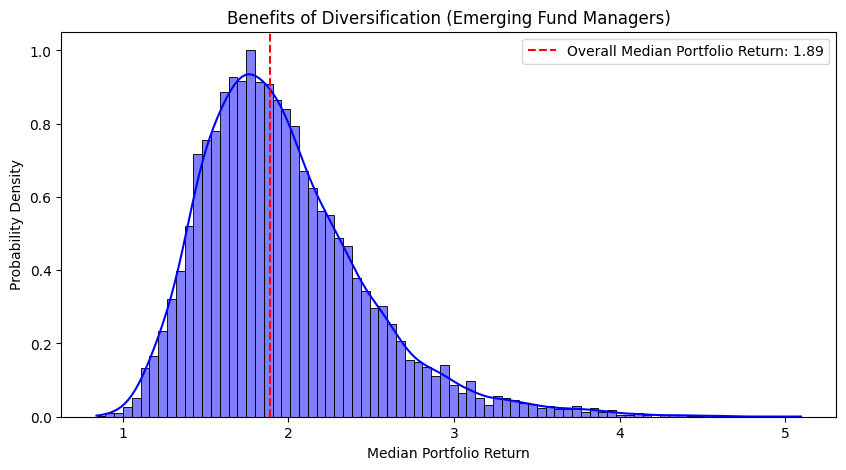

Simulating Portfolios (Established): 100%|████████████████████████████████| 10000/10000 [02:26<00:00, 68.05portfolio/s]


MOIC Brackets Distribution for Established Fund Managers (Monte Carlo Simulations):
+--------------+------------+
| MOIC Bracket | Percentage |
+--------------+------------+
|    <1.0x     |    0.04    |
|  1.0x<=1.5x  |   10.89    |
|  1.5x<=2.0x  |    43.8    |
|    >2.0x     |   45.27    |
+--------------+------------+


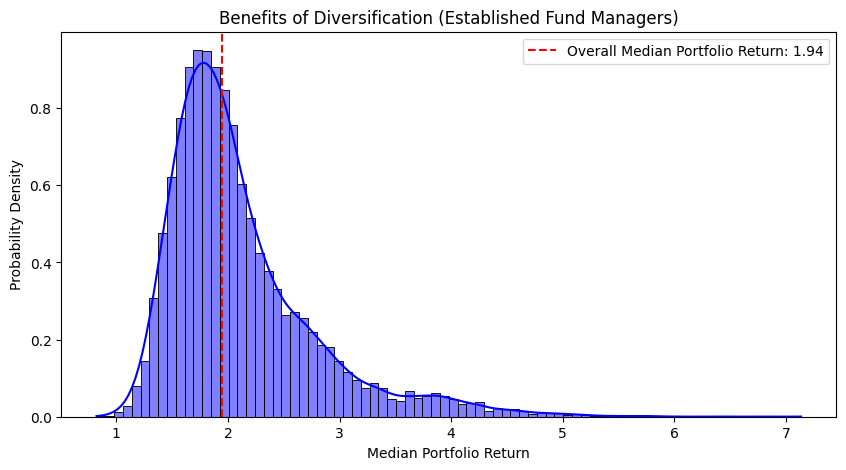

Simulating Portfolios (Emerging & Established): 100%|█████████████████████| 10000/10000 [03:03<00:00, 54.43portfolio/s]


MOIC Brackets Distribution for Emerging & Established Fund Managers (Monte Carlo Simulations):
+--------------+------------+
| MOIC Bracket | Percentage |
+--------------+------------+
|    <1.0x     |   0.037    |
|  1.0x<=1.5x  |   17.412   |
|  1.5x<=2.0x  |   44.556   |
|    >2.0x     |   37.994   |
+--------------+------------+


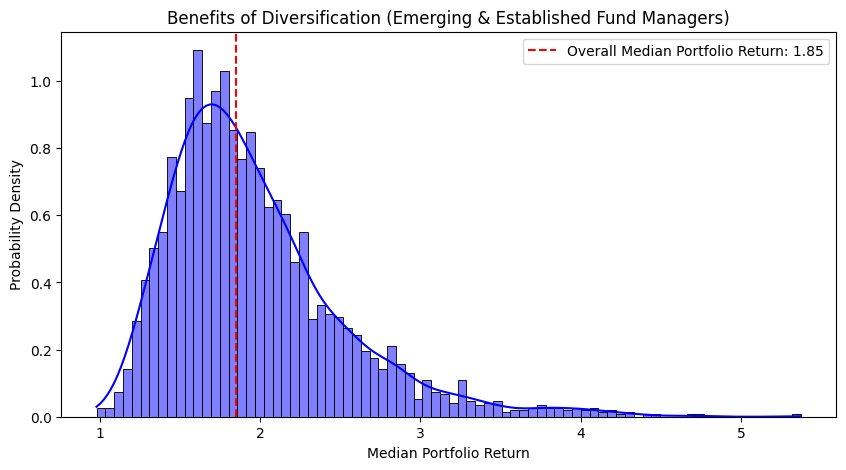

Simulating Portfolios (Emerging & Established (20/80)): 100%|█████████████| 10000/10000 [02:28<00:00, 67.55portfolio/s]


MOIC Brackets Distribution for Emerging & Established (20/80) Fund Managers (Monte Carlo Simulations):
+--------------+------------+
| MOIC Bracket | Percentage |
+--------------+------------+
|    <1.0x     |    0.06    |
|  1.0x<=1.5x  |    12.3    |
|  1.5x<=2.0x  |   44.88    |
|    >2.0x     |   42.76    |
+--------------+------------+


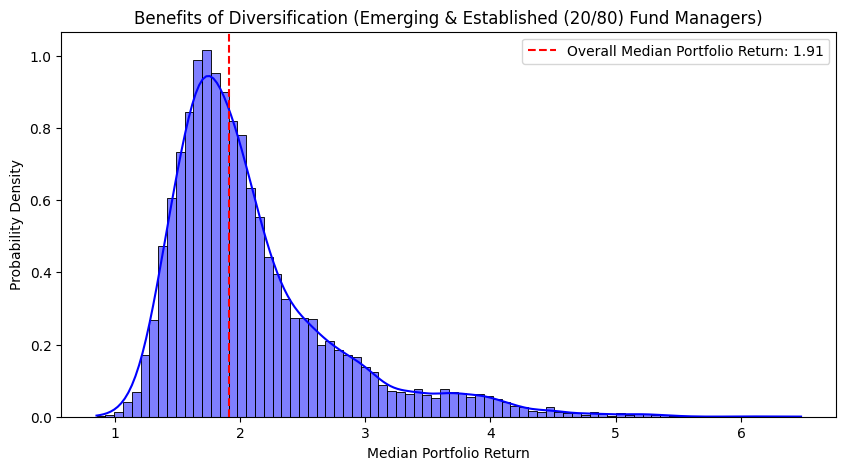

Simulating Portfolios (Emerging & Established (30/70)): 100%|█████████████| 10000/10000 [02:26<00:00, 68.24portfolio/s]


MOIC Brackets Distribution for Emerging & Established (30/70) Fund Managers (Monte Carlo Simulations):
+--------------+------------+
| MOIC Bracket | Percentage |
+--------------+------------+
|    <1.0x     |    0.05    |
|  1.0x<=1.5x  |   12.26    |
|  1.5x<=2.0x  |   43.37    |
|    >2.0x     |   44.32    |
+--------------+------------+


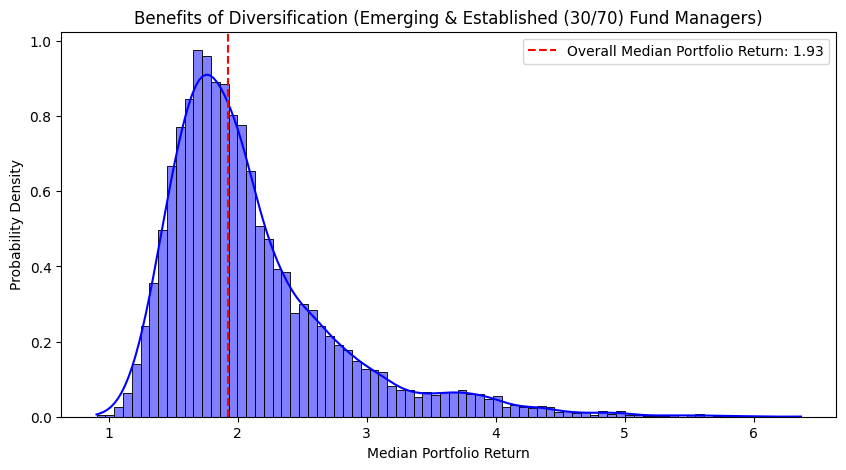

Simulating Portfolios (Emerging & Established (40/60)): 100%|█████████████| 10000/10000 [02:28<00:00, 67.35portfolio/s]


MOIC Brackets Distribution for Emerging & Established (40/60) Fund Managers (Monte Carlo Simulations):
+--------------+------------+
| MOIC Bracket | Percentage |
+--------------+------------+
|    <1.0x     |    0.06    |
|  1.0x<=1.5x  |   11.72    |
|  1.5x<=2.0x  |   42.92    |
|    >2.0x     |    45.3    |
+--------------+------------+


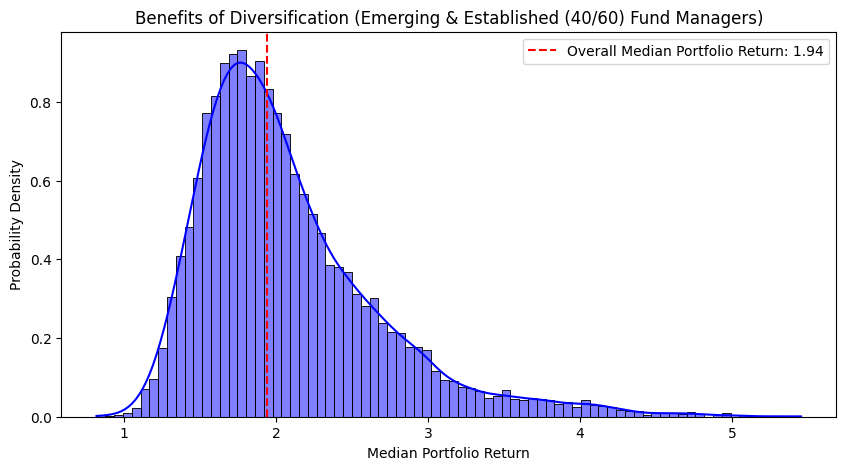

Simulating Portfolios (Emerging & Established (50/50)): 100%|█████████████| 10000/10000 [02:27<00:00, 67.58portfolio/s]


MOIC Brackets Distribution for Emerging & Established (50/50) Fund Managers (Monte Carlo Simulations):
+--------------+------------+
| MOIC Bracket | Percentage |
+--------------+------------+
|    <1.0x     |    0.08    |
|  1.0x<=1.5x  |   13.72    |
|  1.5x<=2.0x  |   47.34    |
|    >2.0x     |   38.86    |
+--------------+------------+


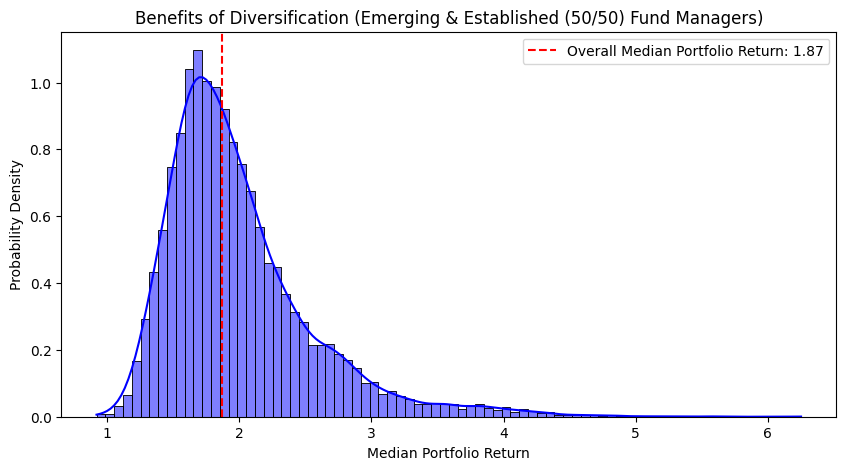

Simulating Portfolios (Emerging & Established (60/40)): 100%|█████████████| 10000/10000 [02:25<00:00, 68.76portfolio/s]


MOIC Brackets Distribution for Emerging & Established (60/40) Fund Managers (Monte Carlo Simulations):
+--------------+------------+
| MOIC Bracket | Percentage |
+--------------+------------+
|    <1.0x     |    0.07    |
|  1.0x<=1.5x  |   11.71    |
|  1.5x<=2.0x  |   39.87    |
|    >2.0x     |   48.35    |
+--------------+------------+


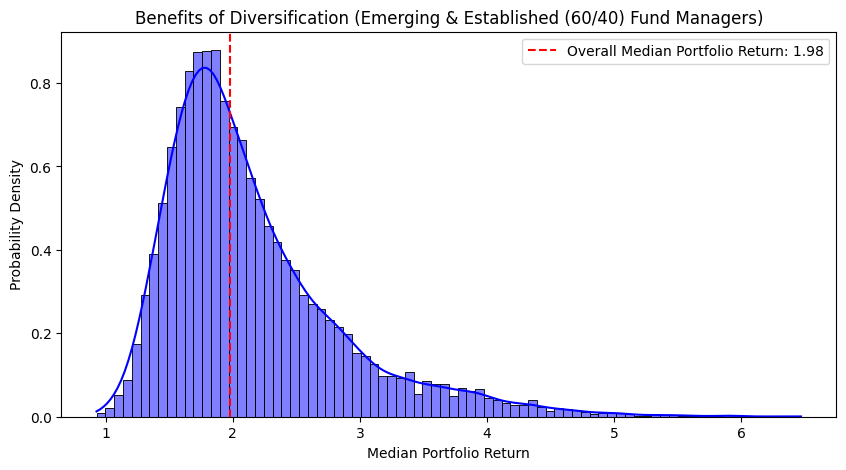

Simulating Portfolios (Emerging & Established (70/30)): 100%|█████████████| 10000/10000 [02:28<00:00, 67.35portfolio/s]


MOIC Brackets Distribution for Emerging & Established (70/30) Fund Managers (Monte Carlo Simulations):
+--------------+------------+
| MOIC Bracket | Percentage |
+--------------+------------+
|    <1.0x     |    0.04    |
|  1.0x<=1.5x  |   13.63    |
|  1.5x<=2.0x  |   42.53    |
|    >2.0x     |    43.8    |
+--------------+------------+


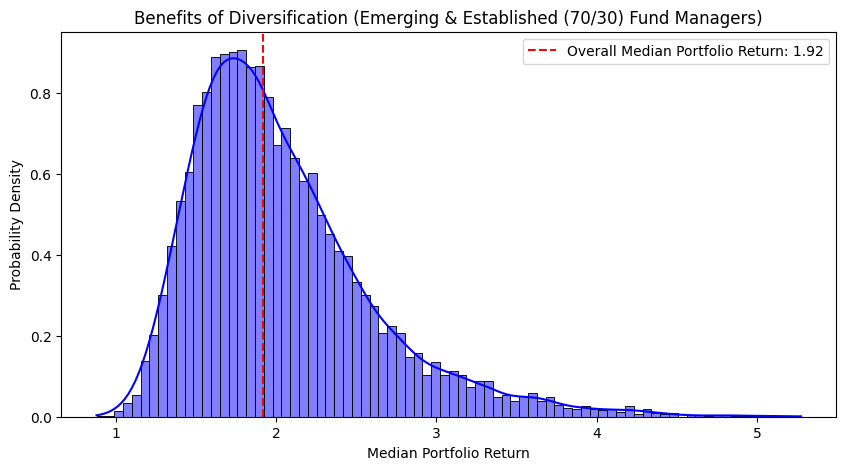

Simulating Portfolios (Emerging & Established (80/20)): 100%|█████████████| 10000/10000 [02:27<00:00, 67.75portfolio/s]


MOIC Brackets Distribution for Emerging & Established (80/20) Fund Managers (Monte Carlo Simulations):
+--------------+------------+
| MOIC Bracket | Percentage |
+--------------+------------+
|    <1.0x     |    0.2     |
|  1.0x<=1.5x  |   17.81    |
|  1.5x<=2.0x  |   46.65    |
|    >2.0x     |   35.34    |
+--------------+------------+


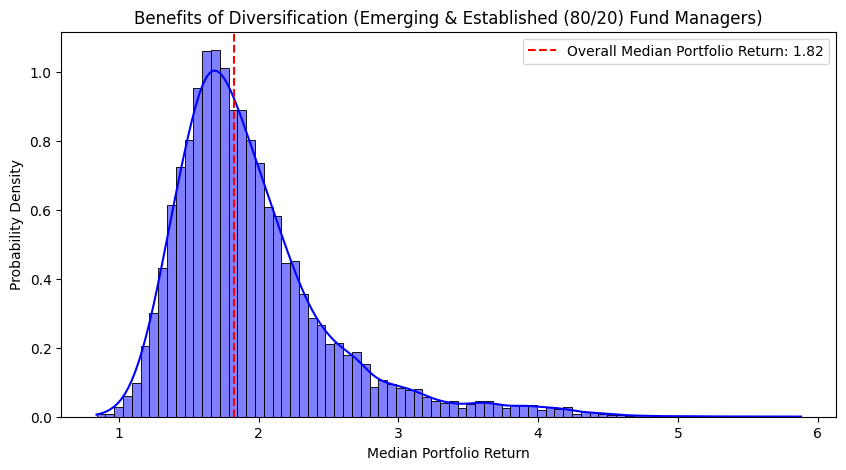

In [124]:
def create_mixed_dataframe(emerging_df, established_df, emerging_num, established_num):
    """
    Create a mixed dataframe with a specified number of funds from both emerging and established datasets.

    Parameters:
    - emerging_df: DataFrame containing data about venture capital funds managed by emerging fund managers (that is either the first or second fund of that fund manager).
    - established_df: DataFrame containing data about venture capital funds managed by established fund managers (that is at least the fifth fund of that fund manager).
    - emerging_num: Number of funds to sample from the emerging dataset (default is None, meaning use all available).
    - established_num: Number of funds to sample from the established dataset (default is None, meaning use all available).

    Returns:
    - mixed_df: Concatenated DataFrame with the specified number of funds from each dataset.
    """
    # Sample a fixed number of funds from each dataset
    emerging_sampled = emerging_df.sample(n = emerging_num, replace = False) if emerging_num is not None else emerging_df
    established_sampled = established_df.sample(n = established_num, replace = False) if established_num is not None else established_df

    # Concatenate the two sampled DataFrames
    mixed_df = pd.concat([emerging_sampled, established_sampled])

    return mixed_df

def simulate_portfolio_median_returns(data, manager_type, returns_column = 8, vintage_column = 'Vintage', n_assets = 15, n_portfolios = 10000, max_iterations = 50):
    """
    Simulate median returns of portfolios based on specified conditions.

    Parameters:
    - data: DataFrame containing the dataset.
    - returns_column: Column index or name containing the returns data.
    - vintage_column: Column index or name containing the vintage information.
    - manager_type: A string indicating the type of fund manager (e.g., 'emerging', 'developing', 'established').
    - n_assets: Number of funds in each portfolio.
    - n_portfolios: Number of portfolios to simulate.
    - max_iterations: Maximum iterations for sampling portfolios.

    Returns:
    - portfolio_median_performances: List of median returns for each simulated portfolio.
    """

    returns = data.iloc[:, returns_column]

    # Initialize empty list to store median performances for each portfolio
    portfolio_median_performances = []
    portfolio_sortino_ratios = []
    portfolio_expected_shortfalls = []

    # Simulate portfolios with tqdm progress bar
    for _ in tqdm(range(n_portfolios), desc = f"Simulating Portfolios ({manager_type})", unit = "portfolio"):
        # Sort vintages in ascending order and sample from the first n_assets
        sorted_vintages = data[vintage_column].sort_values().unique()
        selected_assets = np.random.choice(returns.index.dropna(), n_assets, replace = False)

        # Check if vintages are no more than 3 years apart
        selected_vintages = data.loc[selected_assets, vintage_column]
        vintage_condition = (selected_vintages.max() - selected_vintages.min()) <= 3

        # Continue sampling until the vintage condition is met (with a limit to iterations)
        iterations = 0
        while not vintage_condition and iterations < max_iterations:
            selected_assets = np.random.choice(returns.index.dropna(), n_assets, replace = False)
            selected_vintages = data.loc[selected_assets, vintage_column]
            vintage_condition = (selected_vintages.max() - selected_vintages.min()) <= 3
            iterations += 1

        # Calculate the portfolio's median return directly from the selected assets
        weights = np.ones(n_assets) / n_assets
        portfolio_median_return = np.dot(weights, returns[selected_assets])
        portfolio_median_performances.append(portfolio_median_return)

    # Display the distribution of MOIC brackets for the simulated portfolios
    moic_table = show_portfolio_moic_brackets(portfolio_median_performances, manager_type)
    
    # Calculate the median MOIC across all sampled portfolios
    overall_median_moic = np.nanmedian(portfolio_median_performances)

    plt.figure(figsize = (10, 5))
    sns.histplot(portfolio_median_performances, kde = True, bins = 80, color = 'blue', stat = 'density', common_norm = False)
    plt.axvline(x = overall_median_moic, color = 'red', linestyle = '--', label = f'Overall Median Portfolio Return: {overall_median_moic:.2f}')
    plt.title(f'Benefits of Diversification ({manager_type} Fund Managers)')
    plt.xlabel('Median Portfolio Return')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

    return portfolio_median_performances, moic_table

def show_portfolio_moic_brackets(portfolio_returns, fund_manager_group):
    """
    Show the distribution of MOIC brackets for portfolios of a specific fund manager group.

    Parameters:
    - portfolio_returns: List of portfolio returns.
    - fund_manager_group: A string indicating the fund manager group (e.g., 'emerging', 'developing', 'established').

    Returns:
    - table: Formatted table of MOIC distribution.
    """
    # Categorize portfolio returns into MOIC brackets
    moic_brackets = pd.cut(portfolio_returns, bins = [-np.inf, 1.0, 1.5, 2.0, np.inf],
                           labels = ['<1.0x', '1.0x<=1.5x', '1.5x<=2.0x', '>2.0x'])

    # Calculate the count of portfolios in each MOIC bracket
    moic_counts = moic_brackets.value_counts()

    # Calculate the percentage of portfolios in each MOIC bracket
    moic_percentage = (moic_counts / moic_counts.sum()) * 100

    # Create a DataFrame for tabulation
    table_data = pd.DataFrame({'MOIC Bracket': moic_percentage.index, 'Percentage': moic_percentage.values.round(3)})

    # Format the table using tabulate
    table = tabulate(table_data, headers = 'keys', tablefmt = 'pretty', showindex = False)

    print(f"MOIC Brackets Distribution for {fund_manager_group} Fund Managers (Monte Carlo Simulations):")
    print(table)

    return table

emerging_portfolios, emerging_moic_table = simulate_portfolio_median_returns(
    emerging_fund_managers,
    'Emerging'
)
established_portfolios, established_moic_table = simulate_portfolio_median_returns(
    established_fund_managers,
    'Established'
)
# Simulate portfolios with a mixture of emerging and established fund managers
mixed_portfolios, mixed_moic_table = simulate_portfolio_median_returns(
    data,
    'Emerging & Established'
)

# Create a mixed dataframe with 20% emerging and 80% established
mixed_20_80 = create_mixed_dataframe(emerging_fund_managers, established_fund_managers, emerging_num=int(0.2 * 682), established_num=int(0.8 * 682))
portfolios_20_80, moic_table_20_80 = simulate_portfolio_median_returns(mixed_20_80, 'Emerging & Established (20/80)')

# Create a mixed dataframe with 30% emerging and 70% established
mixed_30_70 = create_mixed_dataframe(emerging_fund_managers, established_fund_managers, emerging_num=int(0.3 * 682), established_num=int(0.7 * 682))
portfolios_30_70, moic_table_30_70 = simulate_portfolio_median_returns(mixed_30_70, 'Emerging & Established (30/70)')

# Create a mixed dataframe with 40% emerging and 60% established
mixed_40_60 = create_mixed_dataframe(emerging_fund_managers, established_fund_managers, emerging_num=int(0.4 * 682), established_num=int(0.6 * 682))
portfolios_40_60, moic_table_40_60 = simulate_portfolio_median_returns(mixed_40_60, 'Emerging & Established (40/60)')

# Create a mixed dataframe with 50% emerging and 50% established
mixed_50_50 = create_mixed_dataframe(emerging_fund_managers, established_fund_managers, emerging_num=int(0.5 * 682), established_num=int(0.5 * 682))
portfolios_50_50, moic_table_50_50 = simulate_portfolio_median_returns(mixed_50_50, 'Emerging & Established (50/50)')

# Create a mixed dataframe with 60% emerging and 40% established
mixed_60_40 = create_mixed_dataframe(emerging_fund_managers, established_fund_managers, emerging_num=int(0.6 * 682), established_num=int(0.4 * 682))
portfolios_60_40, moic_table_60_40 = simulate_portfolio_median_returns(mixed_60_40, 'Emerging & Established (60/40)')

# Create a mixed dataframe with 70% emerging and 30% established
mixed_70_30 = create_mixed_dataframe(emerging_fund_managers, established_fund_managers, emerging_num=int(0.7 * 682), established_num=int(0.3 * 682))
portfolios_70_30, moic_table_470_30 = simulate_portfolio_median_returns(mixed_70_30, 'Emerging & Established (70/30)')

# Create a mixed dataframe with 80% emerging and 20% established
mixed_80_20 = create_mixed_dataframe(emerging_fund_managers, established_fund_managers, emerging_num=int(0.8 * 682), established_num=int(0.2 * 682))
portfolios_80_20, moic_table_80_20 = simulate_portfolio_median_returns(mixed_80_20, 'Emerging & Established (80/20)')

In [57]:
from scipy.stats import norm

def simulate_portfolio_metrics(data, returns_column, vintage_column, manager_type, n_assets=15, n_portfolios=1000, max_iterations=50, risk_free_rate=0.05):
    """
    Simulate portfolio metrics (median return, Sortino ratio, expected shortfall) based on specified conditions.

    Parameters:
    - data: DataFrame containing the dataset.
    - returns_column: Column index or name containing the returns data.
    - vintage_column: Column index or name containing the vintage information.
    - manager_type: A string indicating the type of fund manager (e.g., 'emerging', 'developing', 'established').
    - n_assets: Number of funds in each portfolio.
    - n_portfolios: Number of portfolios to simulate.
    - max_iterations: Maximum iterations for sampling portfolios.
    - risk_free_rate: Risk-free rate for calculating Sortino ratio.

    Returns:
    - portfolio_metrics: DataFrame containing portfolio metrics.
    """

    returns = data.iloc[:, returns_column]

    # Initialize empty lists to store portfolio metrics
    portfolio_median_performances = []
    portfolio_sortino_ratios = []
    portfolio_expected_shortfalls = []

    # Simulate portfolios with tqdm progress bar
    for _ in tqdm(range(n_portfolios), desc=f"Simulating Portfolios ({manager_type})", unit="portfolio"):
        # Sort vintages in ascending order and sample from the first n_assets
        sorted_vintages = data[vintage_column].sort_values().unique()
        selected_assets = np.random.choice(returns.index.dropna(), n_assets, replace=False)
        
        # Check if vintages are no more than 3 years apart
        selected_vintages = data.loc[selected_assets, vintage_column]
        vintage_condition = (selected_vintages.max() - selected_vintages.min()) <= 3
        
        # Continue sampling until the vintage condition is met (with a limit to iterations)
        iterations = 0
        while not vintage_condition and iterations < max_iterations:
            selected_assets = np.random.choice(returns.index.dropna(), n_assets, replace=False)
            selected_vintages = data.loc[selected_assets, vintage_column]
            vintage_condition = (selected_vintages.max() - selected_vintages.min()) <= 3
            iterations += 1

        # Calculate the portfolio's median return directly from the selected assets
        weights = np.ones(n_assets) / n_assets
        portfolio_median_return = np.dot(weights, returns[selected_assets])

        # Calculate downside deviation for Sortino ratio
        downside_returns = np.minimum(returns[selected_assets] - risk_free_rate, 0)
        downside_deviation = np.sqrt(np.mean(downside_returns**2))

        # Calculate Sortino ratio
        if downside_deviation != 0:
            sortino_ratio = (portfolio_median_return - risk_free_rate) / downside_deviation
        else:
            sortino_ratio = np.nan

        # Calculate expected shortfall at 95%
        alpha = 0.05
        es_95 = -np.percentile(returns[selected_assets], alpha * 100)

        # Append metrics to lists
        portfolio_median_performances.append(portfolio_median_return)
        portfolio_sortino_ratios.append(sortino_ratio)
        portfolio_expected_shortfalls.append(es_95)

    # Create a DataFrame for tabulation
    portfolio_metrics = pd.DataFrame({
        'Median Portfolio Return': portfolio_median_performances,
        'Sortino Ratio': portfolio_sortino_ratios,
        'Expected Shortfall (95%)': portfolio_expected_shortfalls
    })

    print(f"Portfolio Metrics for {manager_type} Fund Managers:")
    print(portfolio_metrics.describe())

    return portfolio_metrics

emerging_metrics = simulate_portfolio_metrics(emerging_fund_managers, 8, 'Vintage', 'Emerging', n_assets=15, n_portfolios=1000, max_iterations=50)

Simulating Portfolios (Emerging): 100%|█████████████████████████████████████| 1000/1000 [00:15<00:00, 64.52portfolio/s]

Portfolio Metrics for Emerging Fund Managers:
       Median Portfolio Return  Sortino Ratio  Expected Shortfall (95%)
count              1000.000000     129.000000               1000.000000
mean                  1.963560     248.362334                 -0.532726
std                   0.501817     164.364369                  0.240907
min                   1.015664      83.850530                 -1.349114
25%                   1.603036     148.622773                 -0.698900
50%                   1.879454     183.061443                 -0.522459
75%                   2.233195     290.428715                 -0.367200
max                   4.365678    1025.311565                 -0.000000
